## Description

**Linear regression and logistic regression are the two most widely used statistical models and act like master keys, unlocking the secrets hidden in datasets.**

In [132]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm, logit
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from itertools import product
from scipy.optimize import minimize
from scipy.stats import norm,logistic

### Parallel Slopes

In [12]:
taiwan_real_estate = pd.read_csv('taiwan_real_estate2.csv')

In [13]:
# Fit a linear regression of price_twd_msq vs. n_convenience
mdl_price_vs_conv = ols("price_twd_msq ~ n_convenience",
                        data=taiwan_real_estate).fit()

# Fit a linear regression of price_twd_msq vs. house_age_years, no intercept
mdl_price_vs_age = ols("price_twd_msq ~ house_age_years + 0", data=taiwan_real_estate).fit()

# Fit a linear regression of price_twd_msq vs. n_convenience plus house_age_years, no intercept
mdl_price_vs_both = ols("price_twd_msq ~ n_convenience + house_age_years + 0", data=taiwan_real_estate).fit()

# Print the coefficients
print(mdl_price_vs_both.params)

house_age_years[0 to 15]     9.413325
house_age_years[15 to 30]    7.085169
house_age_years[30 to 45]    7.510958
n_convenience                0.791457
dtype: float64


**Notice how the intercept and slope coefficients change with each model. How to interpret them?**

- For each additional nearby convenience store, the expected house price, in TWD per square meter, increases by 0.79.
- For a house aged 0 to 15 years with zero nearby convenience stores, the expected house price is 9.41 TWD per square meter.

#### Visualizing each explanatory variable

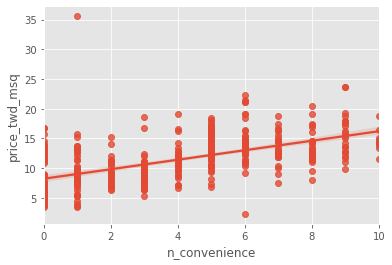

In [14]:
# Create a scatter plot with linear trend line of price_twd_msq vs. n_convenience
sns.regplot(x = 'n_convenience', y = 'price_twd_msq', data = taiwan_real_estate)

# Show the plot
plt.show()

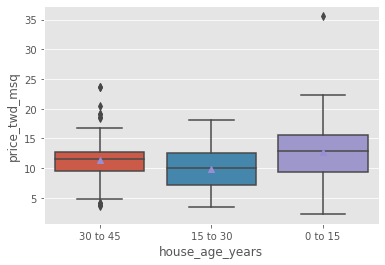

In [15]:
# Create a boxplot of price_twd_msq vs. house_age_years
sns.boxplot(x = 'house_age_years', y = 'price_twd_msq', data = taiwan_real_estate, showmeans = True )

# Show the plot
plt.show()

In [34]:
# Extract the model coefficients, coeffs
coeffs = mdl_price_vs_both.params

# Assign each of the coeffs
ic_0_15, ic_15_30, ic_30_45, slope = coeffs

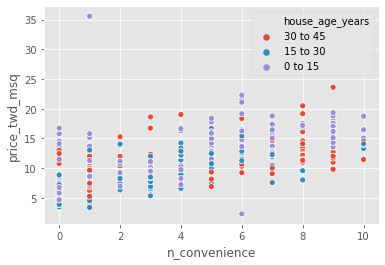

In [36]:
# Draw a scatter plot of price_twd_msq vs. n_convenience, colored by house_age_years
sns.scatterplot(x="n_convenience",
                y="price_twd_msq",
                hue="house_age_years",
                data=taiwan_real_estate)

In [39]:
# Create n_convenience as an array of numbers from 0 to 10
n_convenience = np.arange(0,11)

# Extract the unique values of house_age_years
house_age_years = taiwan_real_estate['house_age_years'].unique()

# Create p as all combinations of values of n_convenience and house_age_years
p = product(n_convenience, house_age_years)

# Transform p to a DataFrame and name the columns
explanatory_data = pd.DataFrame(p, columns = ["n_convenience", "house_age_years"])

print(explanatory_data)

    n_convenience house_age_years
0               0        30 to 45
1               0        15 to 30
2               0         0 to 15
3               1        30 to 45
4               1        15 to 30
5               1         0 to 15
6               2        30 to 45
7               2        15 to 30
8               2         0 to 15
9               3        30 to 45
10              3        15 to 30
11              3         0 to 15
12              4        30 to 45
13              4        15 to 30
14              4         0 to 15
15              5        30 to 45
16              5        15 to 30
17              5         0 to 15
18              6        30 to 45
19              6        15 to 30
20              6         0 to 15
21              7        30 to 45
22              7        15 to 30
23              7         0 to 15
24              8        30 to 45
25              8        15 to 30
26              8         0 to 15
27              9        30 to 45
28            

In [40]:
# Add predictions to the DataFrame
prediction_data = explanatory_data.assign( 
      price_twd_msq = mdl_price_vs_both.predict(explanatory_data))

print(prediction_data)

    n_convenience house_age_years  price_twd_msq
0               0        30 to 45       7.510958
1               0        15 to 30       7.085169
2               0         0 to 15       9.413325
3               1        30 to 45       8.302415
4               1        15 to 30       7.876627
5               1         0 to 15      10.204782
6               2        30 to 45       9.093873
7               2        15 to 30       8.668084
8               2         0 to 15      10.996239
9               3        30 to 45       9.885330
10              3        15 to 30       9.459541
11              3         0 to 15      11.787696
12              4        30 to 45      10.676787
13              4        15 to 30      10.250998
14              4         0 to 15      12.579153
15              5        30 to 45      11.468244
16              5        15 to 30      11.042455
17              5         0 to 15      13.370610
18              6        30 to 45      12.259701
19              6   

In [60]:
# Extract the model coefficients, coeffs
coeffs = mdl_price_vs_both.params

# Print coeffs
print(coeffs)

# Assign each of the coeffs
ic_0_15, ic_15_30, ic_30_45, slope = coeffs

house_age_years[0 to 15]     9.413325
house_age_years[15 to 30]    7.085169
house_age_years[30 to 45]    7.510958
n_convenience                0.791457
dtype: float64


In [87]:
# Define conditions
conditions = [
    explanatory_data["house_age_years"] == "0 to 15",
    explanatory_data["house_age_years"] == "15 to 30",
    explanatory_data["house_age_years"] == "30 to 45"]

# Define choices
choices = [ic_0_15, ic_15_30, ic_30_45]

# Create array of intercepts for each house_age_year category
intercept = np.select(conditions, choices)

# Create prediction_data with columns intercept and price_twd_msq
prediction_data = explanatory_data.assign(
    intercept = intercept,
    price_twd_msq = intercept + slope * explanatory_data["n_convenience"])

print(prediction_data)

    n_convenience house_age_years  intercept  price_twd_msq
0               0        30 to 45   7.510958       7.510958
1               0        15 to 30   7.085169       7.085169
2               0         0 to 15   9.413325       9.413325
3               1        30 to 45   7.510958       8.302415
4               1        15 to 30   7.085169       7.876627
5               1         0 to 15   9.413325      10.204782
6               2        30 to 45   7.510958       9.093873
7               2        15 to 30   7.085169       8.668084
8               2         0 to 15   9.413325      10.996239
9               3        30 to 45   7.510958       9.885330
10              3        15 to 30   7.085169       9.459541
11              3         0 to 15   9.413325      11.787696
12              4        30 to 45   7.510958      10.676787
13              4        15 to 30   7.085169      10.250998
14              4         0 to 15   9.413325      12.579153
15              5        30 to 45   7.51

### Comparing coefficients of determination

In [88]:
# Print the coeffs of determination for mdl_price_vs_conv
print("rsquared_conv: ", mdl_price_vs_conv.rsquared)
print("rsquared_adj_conv: ", mdl_price_vs_conv.rsquared_adj)

# Print the coeffs of determination for mdl_price_vs_age
print("rsquared_age: ", mdl_price_vs_age.rsquared)
print("rsquared_adj_age: ", mdl_price_vs_age.rsquared_adj)

# Print the coeffs of determination for mdl_price_vs_both
print("rsquared_both: ", mdl_price_vs_both.rsquared)
print("rsquared_adj_both: ", mdl_price_vs_both.rsquared_adj)

rsquared_conv:  0.32604660851305045
rsquared_adj_conv:  0.32441079931041217
rsquared_age:  0.08382749316665172
rsquared_adj_age:  0.07936923279276686
rsquared_both:  0.39517387968887374
rsquared_adj_both:  0.3907483227109875


**When both explanatory variables are included in the model, the adjusted coefficient of determination is higher, resulting in a better fit.**

#### Comparing residual standard error

In [89]:
# Print the RSE for mdl_price_vs_conv
print("rse_conv: ", np.sqrt(mdl_price_vs_conv.mse_resid))

# Print the RSE for mdl_price_vs_age
print("rse_age: ", np.sqrt(mdl_price_vs_age.mse_resid))

# Print RSE for mdl_price_vs_both
print("rse_both: ", np.sqrt(mdl_price_vs_both.mse_resid))

rse_conv:  3.383887521343046
rse_age:  3.950183875630859
rse_both:  3.213460280552323


**By including both explanatory variables in the model, a lower RSE was achieved, indicating a smaller difference between the predicted responses and the actual responses.**

## Interactions

### One model per category

In [90]:
# Filter for rows where house age is 0 to 15 years
taiwan_0_to_15 = taiwan_real_estate[taiwan_real_estate["house_age_years"] == "0 to 15"]

# Filter for rows where house age is 15 to 30 years
taiwan_15_to_30 = taiwan_real_estate[taiwan_real_estate["house_age_years"] == "15 to 30"]

# Filter for rows where house age is 30 to 45 years
taiwan_30_to_45 = taiwan_real_estate[taiwan_real_estate["house_age_years"] == "30 to 45"]

# Model price vs. no. convenience stores using 0 to 15 data
mdl_0_to_15 = ols(formula = 'price_twd_msq ~ n_convenience', data = taiwan_0_to_15).fit()

# Model price vs. no. convenience stores using 15 to 30 data
mdl_15_to_30 = ols(formula = 'price_twd_msq ~ n_convenience', data = taiwan_15_to_30).fit()

# Model price vs. no. convenience stores using 30 to 45 data
mdl_30_to_45 = ols(formula = 'price_twd_msq ~ n_convenience', data = taiwan_30_to_45).fit()

# Print the coefficients
print(mdl_0_to_15.params)
print(mdl_15_to_30.params)
print(mdl_30_to_45.params)

Intercept        9.241702
n_convenience    0.833587
dtype: float64
Intercept        6.871919
n_convenience    0.851917
dtype: float64
Intercept        8.113123
n_convenience    0.668698
dtype: float64


In [91]:
# Create explanatory_data, setting no. of conv stores from  0 to 10
explanatory_data = pd.DataFrame({'n_convenience': np.arange(0, 11)})

# Add column of predictions using "0 to 15" model and explanatory data 
prediction_data_0_to_15 = explanatory_data.assign(
                 price_twd_msq = mdl_0_to_15.predict(explanatory_data)    
)

# Same again, with "15 to 30"
prediction_data_15_to_30 = explanatory_data.assign(
                 price_twd_msq = mdl_15_to_30.predict(explanatory_data)    
)

# Same again, with "30 to 45"
prediction_data_30_to_45 = explanatory_data.assign(
                 price_twd_msq = mdl_30_to_45.predict(explanatory_data)    
)

print(prediction_data_0_to_15)
print(prediction_data_15_to_30)
print(prediction_data_30_to_45)

    n_convenience  price_twd_msq
0               0       9.241702
1               1      10.075289
2               2      10.908876
3               3      11.742462
4               4      12.576049
5               5      13.409636
6               6      14.243222
7               7      15.076809
8               8      15.910396
9               9      16.743982
10             10      17.577569
    n_convenience  price_twd_msq
0               0       6.871919
1               1       7.723836
2               2       8.575753
3               3       9.427670
4               4      10.279588
5               5      11.131505
6               6      11.983422
7               7      12.835339
8               8      13.687257
9               9      14.539174
10             10      15.391091
    n_convenience  price_twd_msq
0               0       8.113123
1               1       8.781822
2               2       9.450520
3               3      10.119218
4               4      10.787916
5         

#### Visualizing multiple models

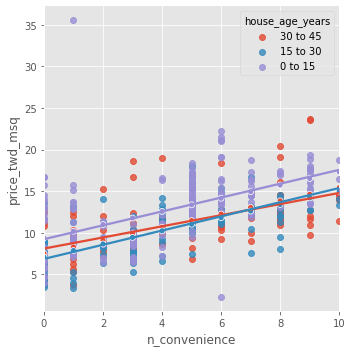

In [93]:
# Plot the trend lines of price_twd_msq vs. n_convenience for each house age category
sns.lmplot(x="n_convenience",
           y="price_twd_msq",
           data=taiwan_real_estate,
           hue="house_age_years",
           ci=None,
           legend_out=False)

# Add a scatter plot for prediction_data
sns.scatterplot(x="n_convenience",
                y="price_twd_msq",
                data=prediction_data,
                hue='house_age_years' ,
                legend=False)

plt.show()

**It's a good sign that our predictions match those of `lmplot's`. Notice that the 30 to 45 year house age group has a much shallower slope compared to the other lines.**

### Assessing model performance

In [95]:
# Print the coeff. of determination for mdl_0_to_15
print("R-squared for mdl_0_to_15: ", (mdl_0_to_15.rsquared))

# Print the coeff. of determination for mdl_15_to_30
print("R-squared for mdl_15_to_30: ", (mdl_15_to_30.rsquared))

# Print the coeff. of determination for mdl_30_to_45
print("R-squared for mdl_30_to_45: ", (mdl_30_to_45.rsquared))

R-squared for mdl_0_to_15:  0.3120536339435179
R-squared for mdl_15_to_30:  0.4424604869682425
R-squared for mdl_30_to_45:  0.3125713334387281


In [96]:
# Print the RSE for mdl_0_to_15
print("RSE for mdl_0_to_15: ", np.sqrt(mdl_0_to_15.mse_resid))

# Print the RSE for mdl_15_to_30
print("RSE for mdl_15_to_30: ", np.sqrt(mdl_15_to_30.mse_resid))

# Print the RSE for mdl_30_to_45
print("RSE for mdl_30_to_45: ", np.sqrt(mdl_30_to_45.mse_resid))


RSE for mdl_0_to_15:  3.5641269936319704
RSE for mdl_15_to_30:  2.585272870907339
RSE for mdl_30_to_45:  3.239037479434981


**It seems that both metrics for the 15 to 30 age group model are much better than those for the whole dataset model, but the models for the other two age groups are similar to the whole dataset model. Thus, using individual models will improve predictions for 15 to 30 age group.**

### Specifying an interaction

In [97]:
# Model price vs both with an interaction using "times" syntax
mdl_price_vs_both_inter = ols(formula = 'price_twd_msq ~ n_convenience * house_age_years', data = taiwan_real_estate).fit()

# Print the coefficients
print(mdl_price_vs_both_inter.params)

Intercept                                    9.241702
house_age_years[T.15 to 30]                 -2.369784
house_age_years[T.30 to 45]                 -1.128579
n_convenience                                0.833587
n_convenience:house_age_years[T.15 to 30]    0.018331
n_convenience:house_age_years[T.30 to 45]   -0.164889
dtype: float64


In [98]:
# Model price vs. both with an interaction using "colon" syntax
mdl_price_vs_both_inter =  ols(formula = 'price_twd_msq ~ n_convenience + house_age_years + n_convenience:house_age_years', data = taiwan_real_estate).fit()

# Print the coefficients
print(mdl_price_vs_both_inter.params)

Intercept                                    9.241702
house_age_years[T.15 to 30]                 -2.369784
house_age_years[T.30 to 45]                 -1.128579
n_convenience                                0.833587
n_convenience:house_age_years[T.15 to 30]    0.018331
n_convenience:house_age_years[T.30 to 45]   -0.164889
dtype: float64


**Notice that the model coefficients are the same in each case. The formula syntax is very flexible, giving you a choice between 'easy to type' and 'very explicit', depending on your preference.**

#### Interactions with understandable coeffs

In [99]:
# Model price vs. house age plus an interaction, no intercept
mdl_readable_inter = ols(formula = 'price_twd_msq ~  house_age_years + n_convenience:house_age_years + 0', data = taiwan_real_estate).fit()


# Print the coefficients for mdl_0_to_15
print("mdl_0_to_15 coefficients:", "\n", mdl_0_to_15.params)

# Print the coefficients for mdl_15_to_30
print("mdl_15_to_30 coefficients:", "\n", mdl_15_to_30.params)

# Print the coefficients for mdl_30_to_45
print("mdl_30_to_45 coefficients:", "\n", mdl_30_to_45.params)

# Print the coefficients for mdl_readable_inter
print("\n", "mdl_readable_inter coefficients:", "\n", mdl_readable_inter.params)

mdl_0_to_15 coefficients: 
 Intercept        9.241702
n_convenience    0.833587
dtype: float64
mdl_15_to_30 coefficients: 
 Intercept        6.871919
n_convenience    0.851917
dtype: float64
mdl_30_to_45 coefficients: 
 Intercept        8.113123
n_convenience    0.668698
dtype: float64

 mdl_readable_inter coefficients: 
 house_age_years[0 to 15]                   9.241702
house_age_years[15 to 30]                  6.871919
house_age_years[30 to 45]                  8.113123
n_convenience:house_age_years[0 to 15]     0.833587
n_convenience:house_age_years[15 to 30]    0.851917
n_convenience:house_age_years[30 to 45]    0.668698
dtype: float64


**The expected increase in house price for each nearby convenience store is lowest for the 30 to 45 year age group.**

### Predicting with interactions

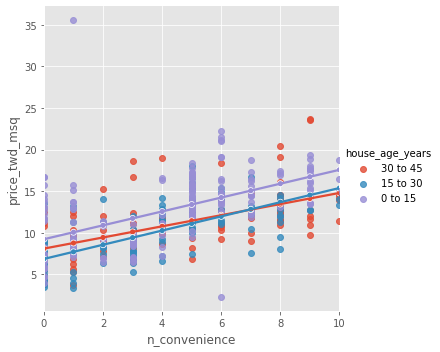

In [100]:
# Create n_convenience as an array of numbers from 0 to 10
n_convenience = np.arange(0, 11)

# Extract the unique values of house_age_years
house_age_years = taiwan_real_estate["house_age_years"].unique()

# Create p as all combinations of values of n_convenience and house_age_years
p = product(n_convenience, house_age_years)

# Transform p to a DataFrame and name the columns
explanatory_data = pd.DataFrame(p, columns=["n_convenience", "house_age_years"])

# Add predictions to the DataFrame
prediction_data = explanatory_data.assign( 
      price_twd_msq = mdl_price_vs_both_inter.predict(explanatory_data))

# Plot the trend lines of price_twd_msq vs. n_convenience colored by house_age_years
sns.lmplot(x = 'n_convenience', y = 'price_twd_msq', hue = 'house_age_years', data = taiwan_real_estate, ci = None)

# Add a scatter plot for prediction_data
sns.scatterplot(x = 'n_convenience', y = 'price_twd_msq', hue = 'house_age_years', data = prediction_data,
     legend=False)

# Show the plot
plt.show()

In [103]:
# Get the coefficients from mdl_price_vs_both_inter
coeffs = mdl_price_vs_both_inter.params

# Assign each of the elements of coeffs
ic_0_15, ic_15_30, ic_30_45, slope_0_15, slope_15_30, slope_30_45 = coeffs

# Create conditions
conditions = [
    explanatory_data["house_age_years"] == "0 to 15",
    explanatory_data["house_age_years"] == "15 to 30",
    explanatory_data["house_age_years"] == "30 to 45"
]

# Create intercept_choices
intercept_choices = [ic_0_15, ic_15_30, ic_30_45]

# Create slope_choices
slope_choices = [slope_0_15, slope_15_30, slope_30_45]

# Create intercept and slope
intercept = np.select(conditions, intercept_choices)
slope = np.select(conditions, slope_choices)

# Create prediction_data with columns intercept and price_twd_msq
prediction_data = explanatory_data.assign(
    price_twd_msq = intercept + slope * explanatory_data['n_convenience']
)

# Print it
print(prediction_data)

    n_convenience house_age_years  price_twd_msq
0               0        30 to 45      -1.128579
1               0        15 to 30      -2.369784
2               0         0 to 15       9.241702
3               1        30 to 45      -1.293467
4               1        15 to 30      -2.351453
5               1         0 to 15      10.075289
6               2        30 to 45      -1.458356
7               2        15 to 30      -2.333122
8               2         0 to 15      10.908876
9               3        30 to 45      -1.623244
10              3        15 to 30      -2.314792
11              3         0 to 15      11.742462
12              4        30 to 45      -1.788133
13              4        15 to 30      -2.296461
14              4         0 to 15      12.576049
15              5        30 to 45      -1.953021
16              5        15 to 30      -2.278131
17              5         0 to 15      13.409636
18              6        30 to 45      -2.117910
19              6   

### Modeling eBay auctions

**Sometimes modeling a whole dataset suggests trends that disagree with models on separate parts of that dataset. This is known as Simpson's paradox. In the most extreme case, you may see a positive slope on the whole dataset, and negative slopes on every subset of that dataset (or the other way around).**

In [105]:
auctions = pd.read_csv('auctions.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         343 non-null    float64
 1   openbid       343 non-null    float64
 2   auction_type  343 non-null    object 
dtypes: float64(2), object(1)
memory usage: 8.2+ KB
None
Intercept    229.245667
openbid       -0.002098
dtype: float64


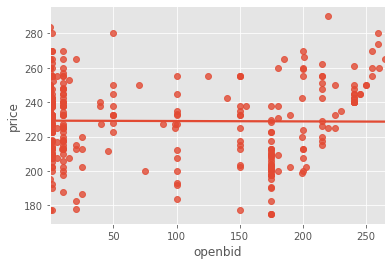

In [106]:
# Take a glimpse at the dataset
print(auctions.info())

# Model price vs. opening bid using auctions
mdl_price_vs_openbid = ols("price ~ openbid", data = auctions).fit()

# See the result
print(mdl_price_vs_openbid.params)

# Plot the scatter plot pf price vs. openbid with a linear trend line
sns.regplot(x = 'openbid', y = 'price', data = auctions, ci = None)

# Show the plot
plt.show()

**The slope coefficient is small enough that it might as well be zero. That is, opening bid appears to have no effect on the final sale price for Palm Pilots.**

#### Modeling each auction type

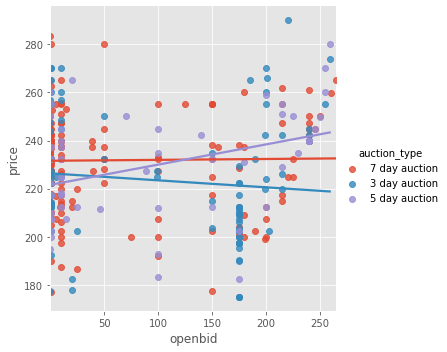

In [107]:
# Fit linear regression of price vs. opening bid and auction type, with an interaction, without intercept
mdl_price_vs_both = ols("price ~ auction_type + openbid:auction_type + 0", data=auctions).fit()

# Using auctions, plot price vs. opening bid colored by auction type as a scatter plot with linear regr'n trend lines
sns.lmplot(x = 'openbid', y = 'price', hue = 'auction_type', data = auctions, ci = None)

# Show the plot
plt.show()

**Interpreting models is a subtle art, and your conclusions need to be based on the question you are trying to answer. Here, the answer to 'Does opening bid affect final sale price?' is no overall, but the answer to 'Does opening bid price affect final sale price for any type of auction?' is yes, for 5 day auctions.**

## Multiple Linear Regression

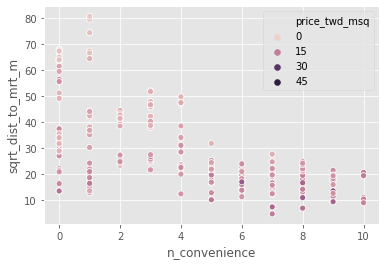

In [108]:
# Transform dist_to_mrt_m to sqrt_dist_to_mrt_m
taiwan_real_estate["sqrt_dist_to_mrt_m"] = np.sqrt(taiwan_real_estate.dist_to_mrt_m)

# Draw a scatter plot of sqrt_dist_to_mrt_m vs. n_convenience colored by price_twd_msq
sns.scatterplot(x = 'n_convenience', y = 'sqrt_dist_to_mrt_m', hue = 'price_twd_msq', data = taiwan_real_estate)

# Show the plot
plt.show()

**Using color for the numeric response variable is a great alternative for 3D scatter plots. The plot suggests that prices are higher when more convenience stores are nearby or when the distance to the nearest MRT station is short. Additionally, there tend to be more convenience stores when the nearest MRT**

### Modeling two numeric explanatory variables

In [109]:
# Fit linear regression of price vs. no. of conv. stores and sqrt dist. to nearest MRT, no interaction
mdl_price_vs_conv_dist = ols("price_twd_msq ~ n_convenience + sqrt_dist_to_mrt_m", data=taiwan_real_estate).fit()

# Create n_convenience as an array of numbers from 0 to 10
n_convenience = np.arange(0,11)

# Create sqrt_dist_to_mrt_m as an array of numbers from 0 to 80 in steps of 10
sqrt_dist_to_mrt_m = np.arange(0,81,10)

# Create p as all combinations of values of n_convenience and sqrt_dist_to_mrt_m
p = product(n_convenience, sqrt_dist_to_mrt_m)

# Transform p to a DataFrame and name the columns
explanatory_data = pd.DataFrame(p, columns = ['n_convenience', 'sqrt_dist_to_mrt_m'])

# Add column of predictions
prediction_data = explanatory_data.assign(
    price_twd_msq = mdl_price_vs_conv_dist.predict(explanatory_data)
)

# See the result  
print(prediction_data)

    n_convenience  sqrt_dist_to_mrt_m  price_twd_msq
0               0                   0      15.103790
1               0                  10      13.530787
2               0                  20      11.957784
3               0                  30      10.384781
4               0                  40       8.811778
..            ...                 ...            ...
94             10                  40      10.953984
95             10                  50       9.380981
96             10                  60       7.807978
97             10                  70       6.234975
98             10                  80       4.661972

[99 rows x 3 columns]


**The modeling and prediction flow for two numeric variables is just as it was for the previous case that included a categorical variable. `statsmodels` automatically handles this different scenario.**

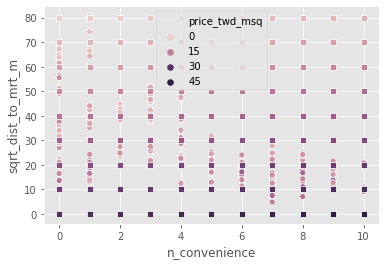

In [110]:
# Create scatter plot of taiwan_real_estate
sns.scatterplot(x = 'n_convenience', y = 'sqrt_dist_to_mrt_m',
hue = 'price_twd_msq', data = taiwan_real_estate)

# Create scatter plot of prediction_data without legend
sns.scatterplot(x = 'n_convenience', y = 'sqrt_dist_to_mrt_m',
hue = 'price_twd_msq', data = prediction_data, legend = False, marker = 's')

# Show the plot
plt.show()

**Plotting a colored grid of predictions can give you a general idea of how your model performs. The prediction grid confirms that your model is a good fit: prices are higher when more convenience stores are nearby or when the distance to the nearest MRT station is short.**

#### Including an interaction

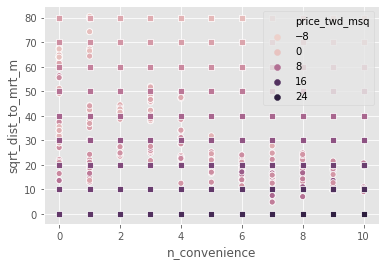

In [112]:
# Convert to mdl_price_vs_conv_dist_inter
mdl_price_vs_conv_dist_inter = ols("price_twd_msq ~ n_convenience * sqrt_dist_to_mrt_m", data=taiwan_real_estate).fit()

# Use mdl_price_vs_conv_dist_inter to make predictions
n_convenience = np.arange(0, 11)
sqrt_dist_to_mrt_m = np.arange(0, 81, 10)
p = product(n_convenience, sqrt_dist_to_mrt_m)
explanatory_data = pd.DataFrame(p, columns=["n_convenience", "sqrt_dist_to_mrt_m"])
prediction_data = explanatory_data.assign(
    price_twd_msq = mdl_price_vs_conv_dist_inter.predict(explanatory_data))

sns.scatterplot(x="n_convenience", y="sqrt_dist_to_mrt_m", data=taiwan_real_estate, hue="price_twd_msq", legend=False)

sns.scatterplot(x="n_convenience", y="sqrt_dist_to_mrt_m", data=prediction_data, hue="price_twd_msq", marker="s")

plt.show()

**Although the predictions from the model are different now that the interaction is included, the code to create them is the same. The resulting prediction grid is not much different from the model without an interaction.**

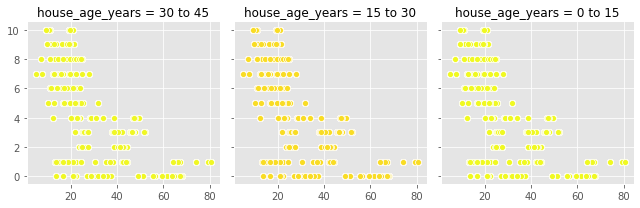

In [114]:
# Prepare the grid using taiwan_real_estate, for each house age category, colored by price_twd_msq
grid = sns.FacetGrid(data=taiwan_real_estate,
            col='house_age_years',
            hue='price_twd_msq',
            palette="plasma")

# Plot the scatterplots with sqrt_dist_to_mrt_m on the x-axis and n_convenience on the y-axis
grid.map(sns.scatterplot,
         x='sqrt_dist_to_mrt_m',
         y='n_convenience',
         data = taiwan_real_estate)

# Show the plot (brighter colors mean higher prices)
plt.show()

**The plot shows the same as before: house price increases with shorter distances to the nearest MRT station, and increases with the number of nearby convenience stores. Faceting by house age suggests that this effect is similar for all house age groups. As you add more variables, it becomes increasingly challenging to create an easily interpretable plot.**

In [115]:
# Model price vs. no. of conv. stores, sqrt dist. to MRT station & house age, no global intercept, no interactions
mdl_price_vs_all_no_inter = ols(formula = 'price_twd_msq ~ n_convenience + sqrt_dist_to_mrt_m + house_age_years + 0', data = taiwan_real_estate).fit()

# See the result
print(mdl_price_vs_all_no_inter.params)

house_age_years[0 to 15]     15.474464
house_age_years[15 to 30]    14.130059
house_age_years[30 to 45]    13.765494
n_convenience                 0.257666
sqrt_dist_to_mrt_m           -0.148102
dtype: float64


In [116]:
# Model price vs. sqrt dist. to MRT station, no. of conv. stores & house age, no global intercept, 3-way interactions
mdl_price_vs_all_3_way_inter = ols(formula = 'price_twd_msq ~ n_convenience+ sqrt_dist_to_mrt_m + house_age_years + n_convenience:sqrt_dist_to_mrt_m + sqrt_dist_to_mrt_m:house_age_years + n_convenience:house_age_years + n_convenience:sqrt_dist_to_mrt_m:house_age_years + 0', data = taiwan_real_estate).fit()

# See the result
print(mdl_price_vs_all_3_way_inter.params)

house_age_years[0 to 15]                                        16.046849
house_age_years[15 to 30]                                       13.760066
house_age_years[30 to 45]                                       12.088773
n_convenience                                                    0.374982
n_convenience:house_age_years[T.15 to 30]                        0.078370
n_convenience:house_age_years[T.30 to 45]                        0.066720
sqrt_dist_to_mrt_m                                              -0.162944
sqrt_dist_to_mrt_m:house_age_years[T.15 to 30]                   0.036618
sqrt_dist_to_mrt_m:house_age_years[T.30 to 45]                   0.061281
n_convenience:sqrt_dist_to_mrt_m                                -0.008393
n_convenience:sqrt_dist_to_mrt_m:house_age_years[T.15 to 30]    -0.003821
n_convenience:sqrt_dist_to_mrt_m:house_age_years[T.30 to 45]     0.004401
dtype: float64


In [117]:
# Model price vs. sqrt dist. to MRT station, no. of conv. stores & house age, no global intercept, 2-way interactions
mdl_price_vs_all_2_way_inter = ols(formula = 'price_twd_msq ~ n_convenience+ sqrt_dist_to_mrt_m + house_age_years + n_convenience:sqrt_dist_to_mrt_m + sqrt_dist_to_mrt_m:house_age_years + n_convenience:house_age_years + 0', data = taiwan_real_estate).fit()

# See the result
print(mdl_price_vs_all_2_way_inter.params)

house_age_years[0 to 15]                          16.026633
house_age_years[15 to 30]                         13.880791
house_age_years[30 to 45]                         11.926904
n_convenience                                      0.384914
n_convenience:house_age_years[T.15 to 30]         -0.006894
n_convenience:house_age_years[T.30 to 45]          0.143416
sqrt_dist_to_mrt_m                                -0.162025
sqrt_dist_to_mrt_m:house_age_years[T.15 to 30]     0.031600
sqrt_dist_to_mrt_m:house_age_years[T.30 to 45]     0.068198
n_convenience:sqrt_dist_to_mrt_m                  -0.008956
dtype: float64


**The formula syntax is flexible enough to provide precise control over which interactions are specified.**

In [118]:
# Create n_convenience as an array of numbers from 0 to 10
n_convenience = np.arange(0, 11)

# Create sqrt_dist_to_mrt_m as an array of numbers from 0 to 80 in steps of 10
sqrt_dist_to_mrt_m = np.arange(0, 81, 10)

# Create house_age_years with unique values
house_age_years = taiwan_real_estate["house_age_years"].unique()

# Create p as all combinations of n_convenience, sqrt_dist_to_mrt_m, and house_age_years, in that order
p = product(n_convenience, sqrt_dist_to_mrt_m, house_age_years)

# Transform p to a DataFrame and name the columns
explanatory_data = pd.DataFrame(p, columns=["n_convenience",
                                            "sqrt_dist_to_mrt_m",
                                            "house_age_years"])

# Add column of predictions
prediction_data = explanatory_data.assign(
    price_twd_msq = mdl_price_vs_all_3_way_inter.predict(explanatory_data)
)

# See the result
print(prediction_data)

     n_convenience  sqrt_dist_to_mrt_m house_age_years  price_twd_msq
0                0                   0        30 to 45      12.088773
1                0                   0        15 to 30      13.760066
2                0                   0         0 to 15      16.046849
3                0                  10        30 to 45      11.072148
4                0                  10        15 to 30      12.496811
..             ...                 ...             ...            ...
292             10                  70        15 to 30       0.900864
293             10                  70         0 to 15       2.515561
294             10                  80        30 to 45       5.179415
295             10                  80        15 to 30      -1.583811
296             10                  80         0 to 15       0.046831

[297 rows x 4 columns]


**Notice how rapidly the dimensions of the prediction data increase when you are adding more and more variables.**

In [120]:
# Complete the function
def calc_sum_of_squares(coeffs):
    # Unpack coeffs
    intercept, slope = coeffs
    # Calculate predicted y-values
    y_pred = intercept + slope * taiwan_real_estate.n_convenience
    # Calculate differences between y_actual and y_pred
    y_diff = y_pred - taiwan_real_estate.price_twd_msq
    # Calculate sum of squares
    sum_sq = np.sum(y_diff ** 2)
    # Return sum of squares
    return sum_sq

# Call minimize on calc_sum_of_squares  
print(minimize(fun=calc_sum_of_squares,
               x0=[0,0]))

# Compare the output with the ols() call.
print(ols("price_twd_msq ~ n_convenience", data=taiwan_real_estate).fit().params)
  

      fun: 4717.68623992569
 hess_inv: array([[ 0.00354669, -0.00057129],
       [-0.00057129,  0.00013954]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([8.22423749, 0.7980797 ])
Intercept        8.224237
n_convenience    0.798080
dtype: float64


**The results you got here with just a few lines of code are identical to the finely-tuned results from `ols()`. All you needed was a function to calculate the sum of squares metric, and the `minimize()` function worked its magic to find where this function had its minimum value.**

## Multiple Logistic Regression

In [122]:
churn = pd.read_csv('churn.csv')

In [123]:
# Import logit
from statsmodels.formula.api import logit

# Fit a logistic regression of churn status vs. length of relationship, recency, and an interaction
mdl_churn_vs_both_inter = logit(formula = 'has_churned ~ time_since_first_purchase + time_since_last_purchase + time_since_first_purchase:time_since_last_purchase', data = churn).fit()

# Print the coefficients
print(mdl_churn_vs_both_inter.params)

Optimization terminated successfully.
         Current function value: 0.649717
         Iterations 5
Intercept                                            -0.150534
time_since_first_purchase                            -0.637642
time_since_last_purchase                              0.423284
time_since_first_purchase:time_since_last_purchase    0.112250
dtype: float64


In [124]:
# Create time_since_first_purchase
time_since_first_purchase = np.arange(-2, 4.1, 0.1)

# Create time_since_last_purchase
time_since_last_purchase = np.arange(-1, 6.1, 0.1)

# Create p as all combinations of values of time_since_first_purchase and time_since_last_purchase
p = product(time_since_first_purchase, time_since_last_purchase)

# Transform p to a DataFrame and name the columns
explanatory_data = pd.DataFrame(p, columns=["time_since_first_purchase",
                                            "time_since_last_purchase"])

# Create prediction_data
prediction_data = explanatory_data.assign(
    has_churned = mdl_churn_vs_both_inter.predict(explanatory_data)
)

# Create most_likely_outcome
prediction_data["most_likely_outcome"] = np.round(prediction_data.has_churned)

# See the result
print(prediction_data)

      time_since_first_purchase  time_since_last_purchase  has_churned  \
0                          -2.0                      -1.0     0.716256   
1                          -2.0                      -0.9     0.720279   
2                          -2.0                      -0.8     0.724266   
3                          -2.0                      -0.7     0.728218   
4                          -2.0                      -0.6     0.732134   
...                         ...                       ...          ...   
4326                        4.0                       5.6     0.898775   
4327                        4.0                       5.7     0.906440   
4328                        4.0                       5.8     0.913580   
4329                        4.0                       5.9     0.920223   
4330                        4.0                       6.0     0.926396   

      most_likely_outcome  
0                     1.0  
1                     1.0  
2                     1.0  

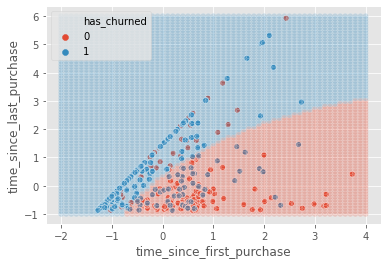

In [127]:
# Using churn, plot recency vs. length of relationship, colored by churn status
sns.scatterplot(x="time_since_first_purchase",
                y="time_since_last_purchase",
                data=churn, 
                hue="has_churned")

# Using prediction_data, plot recency vs. length of relationship, colored by most_likely_outcome
sns.scatterplot(x = 'time_since_first_purchase',
                y = 'time_since_last_purchase',
                hue = 'most_likely_outcome', 
                data = prediction_data,
                alpha=0.2,
                legend=False)

# Show the plot
plt.show()

**The reason why the data points lie on or to the right of the diagonal line is due to nature of the data: the time since the last purchase can't exceed the time since the first purchase. Also notice the pattern of the prediction data: longer customer relationships and shorter purchase recency predicts lower churns.**

#### Confusion matrix

In [128]:
# Create conf_matrix
conf_matrix = mdl_churn_vs_both_inter.pred_table()

# Extract TN, TP, FN and FP from conf_matrix
TN = conf_matrix[0,0]
TP = conf_matrix[1,1]
FN = conf_matrix[1,0]
FP = conf_matrix[0,1]

# Calculate and print the accuracy
accuracy = (TN + TP) / (TN + TP + FN + FP)
print("accuracy", accuracy)

# Calculate and print the sensitivity
sensitivity = TP / (TP + FN)
print("sensitivity", sensitivity)

# Calculate and print the specificity
specificity = TN / (TN + FP)
print("specificity", specificity)

accuracy 0.6225
sensitivity 0.735
specificity 0.51


**Generating a confusion matrix and calculating metrics like accuracy, sensitivity, and specificity is the standard way to measure how well a logistic model fits. Higher accuracy, sensitivity, and specificity is better, though there is often a trade-off between sensitivity and specificity. Compared to the previous solutions where we calculated the metrics for the model with a single explanatory variable, accuracy and sensitivity increased, but specificity decreased.**

### Cumulative distribution function

Understanding the logistic distribution is key to understanding logistic regression. Like the normal (Gaussian) distribution, it is a probability distribution of a single continuous variable. Here you'll visualize the cumulative distribution function (CDF) for the logistic distribution. That is, if you have a logistically distributed variable, x, and a possible value, xval, that x could take, then the CDF gives the probability that x is less than xval.

The logistic distribution's CDF is calculated with the logistic function (hence the name). The plot of this has an S-shape, known as a sigmoid curve. An important property of this function is that it takes an input that can be any number from minus infinity to infinity, and returns a value between zero and one.

In [133]:
# Create x ranging from minus ten to ten in steps of 0.1
x = np.arange(-10, 10.1, 0.1)

# Create logistic_dist
logistic_dist = pd.DataFrame({"x": x,
                              "log_cdf": logistic.cdf(x),
                              "log_cdf_man": 1/(1 + np.exp(-x))})

# Check that each logistic function gives the same results
print(np.array_equal(logistic_dist["log_cdf_man"], logistic_dist["log_cdf_man"]))

True


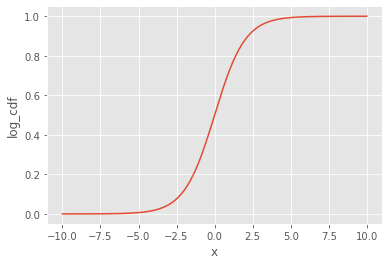

In [134]:
# Using logistic_dist, plot log_cdf vs. x
sns.lineplot(x = 'x',
             y = 'log_cdf',
             data = logistic_dist)
# Show the plot
plt.show()

### Inverse cumulative distribution function

The logistic function (logistic distribution CDF) has another important property: each x input value is transformed to a unique value. That means that the transformation can be reversed. The logit function is the name for the inverse logistic function, which is also the logistic distribution inverse cumulative distribution function. (All three terms mean exactly the same thing.)

The logit function takes values between zero and one, and returns values between minus infinity and infinity.

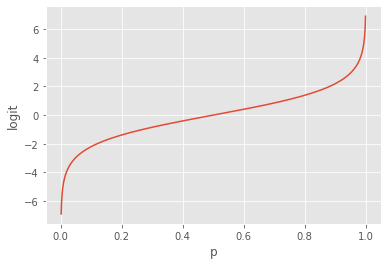

In [137]:
# Create p ranging from 0.001 to 0.999 in steps of 0.001
p = np.arange(0.001, 1, 0.001)

# Create logistic_dist_inv
logistic_dist_inv = pd.DataFrame({"p": p,
                                  "logit": logistic.ppf(p),
                                  "logit_man": np.log(p / (1 - p))})

# Using logistic_dist_inv, plot logit vs. p
sns.lineplot(x = 'p',
             y = 'logit',
             data = logistic_dist_inv)

# Show the plot
plt.show()

**The inverse CDF is the "opposite" transformation to the CDF. If you flip the x and y axes on this plot, you get the same plot you saw in the previous exercise.**

### Logistic regression algorithm

In [138]:
# Complete the function
def calc_neg_log_likelihood(coeffs):
    # Unpack coeffs
    intercept, slope = coeffs
    # Calculate predicted y-values
    y_pred = logistic.cdf(intercept + slope * churn.time_since_last_purchase)
    # Calculate log-likelihood
    log_likelihood = np.log(y_pred) * churn.has_churned + np.log(1 - y_pred) * (1 - churn.has_churned)
    # Calculate negative sum of log_likelihood
    neg_sum_ll = -np.sum(log_likelihood)
    # Return negative sum of log_likelihood
    return neg_sum_ll
  
# Call minimize on calc_sum_of_squares  
print(minimize(fun=calc_neg_log_likelihood,
               x0=[0,0]))

# Compare the output with the logit() call.
print(logit("has_churned ~ time_since_last_purchase", data=churn).fit().params)

      fun: 273.2001452736105
 hess_inv: array([[ 0.01018366, -0.00099003],
       [-0.00099003,  0.00963045]])
      jac: array([-7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.03501947,  0.26921492])
Optimization terminated successfully.
         Current function value: 0.683000
         Iterations 4
Intercept                  -0.035019
time_since_last_purchase    0.269215
dtype: float64


**To make a really simple version of `logit()`, you just needed a function to calculate the negative log-likelihood, and a general-purpose optimization function.**